<a href="https://colab.research.google.com/github/blizrys/MinorThesisBERT/blob/main/BERT_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


Before we start as we are swap between google colabs and local machine. We need to identify the path we store dataset and configuration.

In [ ]:
# Locate path of data in 'google drive'
DATA_PATH = '/content/drive/MyDrive/FIT5212/data/ass1/'
SEED_NUMBER = 19900506

In [ ]:
%matplotlib inline

In [ ]:
# Part1
!pip install spacy #==2.0.11
!pip install transformers
# Part2
!pip3 install gensim
!pip install pyLDAvis==2.1.2
!pip3 install wordcloud

     |████████████████████████████████| 2.1MB 8.6MB/s 
     |████████████████████████████████| 901kB 34.5MB/s 
     |████████████████████████████████| 3.3MB 38.4MB/s 
     |████████████████████████████████| 1.6MB 8.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=8d2859dfc8e1c3392c73851192eadadd18cd2fd0e98fef4a5efe382040c462f6
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


# Assignment 1 for FIT5212, Semester 1, 2021

**Student Name:**  Jirarote Jirasirikul

**Student ID:**    31334679

## Check Available Device (CPU/GPU)

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Part 1:  Text Classification

In this task, we have been assigned to build text classification models using 'abstract' data to determine combination of label 'InfoTheory', 'CompViz' and 'Math'.

The model need to be set with different configurations
- 3 boolean labels
- 2 Algorithm (RNN and Logistic regression statistic classifier)
- 2 Text preprocessing (Lemmatize & Not Lemmatize)
- 2 Data size (First 1000 and all training set)

In total, we will build 24 models for comparison.

**Extra** additional 6 BERT transformer before Logistic regression for comparision (3 Targets * 2 Text preprocessing : BERTTokenize on Abstract and on Lemmatized)




### Import Library

All Library and File Path will be added here

In [ ]:
# SPACY RELATED library
# !pip install spacy #==2.0.11
import spacy
print('spaCy Version: %s' % (spacy.__version__))
spacy_nlp = spacy.load('en_core_web_sm')

spaCy Version: 2.2.4


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.



In [ ]:
# NLTK library
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# PyTorch library
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset
import torch.nn as nn
import torch.optim as optim

# Other library
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

import ast # for eval string to proper datatype

import seaborn as sns

In [ ]:
# transformer for BERT
# !pip install transformers
import transformers as ppb
# import warnings
# warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/packaging/version.py:130: DeprecationWarning:

Creating a LegacyVersion has been deprecated and will be removed in the next major release



### Data Exploration

Now let's wrangle!

In [ ]:
# Load dataset
df_train = pd.read_csv(DATA_PATH+'/dataset/axcs_train.csv')
df_test = pd.read_csv(DATA_PATH+'/dataset/axcs_test.csv')

print("Train size", df_train.shape)
print("Test size", df_test.shape)

Train size (54731, 8)
Test size (19679, 8)


In [ ]:
# Preview train dataset
df_train.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...


In [ ]:
# Preview test dataset
df_test.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,no-150100335,arxiv.org/abs/1501.00335,2015-01-01,A Data Transparency Framework for Mobile Appli...,0.0,0.0,0.0,A Data Transparency Framework for Mobile Appl...
1,no-14024178,arxiv.org/abs/1402.4178,2015-01-01,A reclaimer scheduling problem arising in coal...,0.0,0.0,0.0,A reclaimer scheduling problem arising in coa...
2,no-150100263,arxiv.org/abs/1501.00263,2015-01-01,Communication-Efficient Distributed Optimizati...,0.0,0.0,1.0,Communication-Efficient Distributed Optimizat...


From specification sheet, we will be dealing with only InfoTheory, CompVis, Math and Abstract columns. (Ignore the rest)

Let's check on completeness of our data...

In [ ]:
# check missing value using isnull() function 
pd.concat({"train": df_train.isnull().sum(),
            "test": df_test.isnull().sum()},
          axis = 1)

,train,test
ID,0,0
URL,0,0
Date,0,0
Title,0,0
InfoTheory,0,1
CompVis,0,1
Math,0,1
Abstract,0,1


In [ ]:
df_missing = df_test[df_test.Abstract.isnull() | df_test.Math.isnull()| df_test.CompVis.isnull()| df_test.InfoTheory.isnull()]
df_missing

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
19619,no-160308961,arxiv.org/abs/1603.08961,2016-03-29,Betting and Belief: Prediction Markets and Att...,NaN,NaN,NaN,NaN


We found one sample in test dataset that is missing values. Let's remove it since it's only one out of 19k training datas.

In [ ]:
print('before:',df_test.shape)
df_test.drop(df_missing.index, axis=0,inplace = True)
print('after:',df_test.shape)

before: (19679, 8)
after: (19678, 8)


#### Text Preprocessing

In this section, we will perform text-preprocessing.
It is also possible to perform this when load with pytorch TabularDatasets. 

However, doing this once and save to csv will lessen time when load.

We will do simple tokenization that has similiar step
1. Lower case
2. Tokenize with spacy
3. Remove stop_word using spacy
4. Lemmatize (Lemmatize and Not Lemmatize for 2 different text preprocessing)
5. Remove alphabet with length 1 (but keep full-stop for BERT)

By doing only single steps different will make us see clearer on the impact to modelling.

Doing more diffirent text-preprocessing will be harder to identify the cause.


In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words: %s' % list(spacy_stopwords)[:10])

Number of stop words: 326
First ten stop words: ['of', 'done', 'has', 'meanwhile', 'two', 'a', 'namely', "'ve", 'last', 'regarding']


In [ ]:
def my_tokenize(sentence):
    spacy_tokens = spacy_nlp(sentence.lower())

    # Lemmatize word (or not) and Remove context independent stopwords (spacy)
    tokens_lemma = [token.lemma_ for token in spacy_tokens if not token.is_stop]
    tokens_no_lemma = [token.text for token in spacy_tokens if not token.is_stop]

    # Remove alphabet (word with length <= 1)
    tokens_lemma = [token for token in tokens_lemma if (len(token) > 1 or token == '.')]
    tokens_no_lemma = [token for token in tokens_no_lemma if (len(token) > 1 or token == '.')]
    
    # print('Original sentence: %s' % (sentence))
    # print('Tokenized sentence: %s' % (tokens))
    return [' '.join(tokens_lemma),' '.join(tokens_no_lemma)]

# my_tokenize("This is a good day to die - starcraft")
my_tokenize("Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.")

['lemmatisation lemmatization linguistic process group inflect form word analyse single item identify word lemma dictionary form .',
 'lemmatisation lemmatization linguistics process grouping inflected forms word analysed single item identified word lemma dictionary form .']

In [ ]:
df_train['res'] = df_train.Abstract.apply(lambda x : my_tokenize(x))
df_train[['lemma','no_lemma']] = pd.DataFrame(df_train.res.tolist(), index= df_train.index)

In [ ]:
df_test['res'] = df_test.Abstract.apply(lambda x : my_tokenize(x))
df_test[['lemma','no_lemma']] = pd.DataFrame(df_test.res.tolist(), index= df_test.index)

For best practice when performing modeling. We normally have 3 sets of datasets which is 'Train', 'Validate' and 'Test' datasets.

In this case, we will split Train datasets in to 'Train' and 'Validate' since we would like to retain our 'Test' dataset as unseen data.

In [ ]:
df_train.head()

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract,res,lemma,no_lemma
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...,[nest satisfiability special case satisfiabili...,nest satisfiability special case satisfiabilit...,nested satisfiability special case satisfiabil...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...,[note digitized angle study configuration pixe...,note digitized angle study configuration pixel...,note digitized angles study configurations pix...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...,[textbook example recursion discuss property r...,textbook example recursion discuss property re...,textbook examples recursion discuss properties...
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...,[theory practice author argue silicon valley i...,theory practice author argue silicon valley im...,theory practice author argues silicon valley i...
4,cs-9301115,arxiv.org/abs/cs/9301115,1991-11-30,Context-free multilanguages,0,0,0,Context-free multilanguages This article is a...,[context free multilanguage article sketch ide...,context free multilanguage article sketch idea...,context free multilanguages article sketch ide...


In [ ]:

df_new_train = df_train.sample(frac = 0.9,random_state=SEED_NUMBER)
df_new_valid = df_train.drop(df_new_train.index)
print('df_new_train:',df_new_train.shape)
print('df_new_valid:',df_new_valid.shape)

df_new_1ktrain = df_train[0:1000].sample(frac = 0.9,random_state=SEED_NUMBER)
df_new_1kvalid = df_train[0:1000].drop(df_new_1ktrain.index)
print('df_new_1ktrain:',df_new_1ktrain.shape)
print('df_new_1kvalid:',df_new_1kvalid.shape)

df_new_train: (49258, 11)
df_new_valid: (5473, 11)
df_new_1ktrain: (900, 11)
df_new_1kvalid: (100, 11)


In [ ]:
df_new_train.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract,res,lemma,no_lemma
30603,no-11033240,arxiv.org/abs/1103.3240,2012-10-09,Decentralized Constraint Satisfaction,0,0,0,Decentralized Constraint Satisfaction We show...,[decentralized constraint satisfaction importa...,decentralized constraint satisfaction importan...,decentralized constraint satisfaction importan...
17203,no-10115122,arxiv.org/abs/1011.5122,2010-11-23,Utility Constrained Energy Minimization In Alo...,1,0,1,Utility Constrained Energy Minimization In Al...,[utility constrain energy minimization aloha n...,utility constrain energy minimization aloha ne...,utility constrained energy minimization aloha ...
5614,math-0701801,arxiv.org/abs/math/0701801,2007-01-28,Deterministic modal Bayesian Logic: derive the...,0,0,1,Deterministic modal Bayesian Logic: derive th...,[deterministic modal bayesian logic derive bay...,deterministic modal bayesian logic derive baye...,deterministic modal bayesian logic derive baye...


In [ ]:
df_new_valid.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract,res,lemma,no_lemma
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...,[theory practice author argue silicon valley i...,theory practice author argue silicon valley im...,theory practice author argues silicon valley i...
6,cs-9308102,arxiv.org/abs/cs/9308102,1993-07-31,A Market-Oriented Programming Environment and ...,0,0,0,A Market-Oriented Programming Environment and...,[market orient programming environment applica...,market orient programming environment applicat...,market oriented programming environment applic...
13,cs-9401102,arxiv.org/abs/cs/9401102,1993-12-31,Mini-indexes for literate programs,0,0,0,Mini-indexes for literate programs This paper...,[mini index literate program paper describe im...,mini index literate program paper describe imp...,mini indexes literate programs paper describes...


Save these as cleaned datasets for further use.

In [ ]:
df_new_1ktrain.to_csv(DATA_PATH+'/dataset/1000_axcs_train_cleaned.csv', index=False)
df_new_1kvalid.to_csv(DATA_PATH+'/dataset/1000_axcs_valid_cleaned.csv', index=False)
df_new_train.to_csv(DATA_PATH+'/dataset/axcs_train_cleaned.csv', index=False)
df_new_valid.to_csv(DATA_PATH+'/dataset/axcs_valid_cleaned.csv', index=False)
df_test.to_csv(DATA_PATH+'/dataset/axcs_test_cleaned.csv', index=False)

### Prepare Data for Modeling

In this section, we will load datasets that we have explore previously and simply split as we have perform text-preprocessing already.

In [ ]:
# Predefine Field type
TEXT = data.Field(sequential=True, tokenize = lambda x: x.replace('.','').split(), lower=True)
# TEXT = data.Field(sequential=True, tokenize = lambda x: x.split(), lower=True, include_lengths=True)
# TEXT = data.Field(sequential=True, tokenize = 'spacy', lower=True, include_lengths=True)
# TEXT = data.Field(tokenize = 'spacy', lower=True, include_lengths=True,batch_first=True)
LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=float,batch_first=True,sequential=False)

# Predefine datafields of each column. we pass in 'None' to fields that we won't be needed.
tv_datafields = [("id", None),
                 ("url", None),
                 ('date',None),
                 ("title", None),
                 ("InfoTheory", LABEL),
                 ("CompVis", LABEL),
                 ("Math", LABEL),
                 ("abstract", None),
                 ("res", None),
                 ("lemma", TEXT),
                 ("no_lemma", TEXT)]

#### Dataset 1k data

In [ ]:
df_train1k = pd.read_csv(DATA_PATH+'/dataset/1000_axcs_train_cleaned.csv')
df_valid1k = pd.read_csv(DATA_PATH+'/dataset/1000_axcs_valid_cleaned.csv')
df_test1k = pd.read_csv(DATA_PATH+'/dataset/axcs_test_cleaned.csv')

In [ ]:
# Load the data as TabularDataset. 
# As our datasets doesn't contain 'validate' datasets, we'll split train dataset in to 'train' and 'validate'
train1k_data, valid1k_data, test1k_data = TabularDataset.splits(
    path=DATA_PATH+'dataset/', 
    train='1000_axcs_train_cleaned.csv',
    validation='1000_axcs_valid_cleaned.csv',
    test='axcs_test_cleaned.csv', 
    format='csv',skip_header=True,
    fields=tv_datafields)

# # Check loaded data
# print(f'Number of raw_training examples: {len(raw_spacy_train_data)}')
print(f'-----------------------')
print(f'Number of training examples: {len(train1k_data)}')
print(f'Number of validation examples: {len(valid1k_data)}')
print(f'Number of testing examples: {len(test1k_data)}')

-----------------------
Number of training examples: 900
Number of validation examples: 100
Number of testing examples: 19678


In [ ]:
MAX_VOCAB_SIZE = 30000
TEXT.build_vocab(train1k_data, max_size = MAX_VOCAB_SIZE)
print(len(TEXT.vocab))
print(TEXT.vocab.freqs.most_common(20))
# TEXT.tokenize = lambda x: my_tokenize(x,0) ? Need to find a way to change tokenize of loaded data in tabulardataset

7821
[('language', 1396), ('model', 1102), ('paper', 1056), ('system', 1011), ('algorithm', 843), ('word', 783), ('grammar', 738), ('approach', 737), ('base', 699), ('method', 655), ('information', 640), ('based', 622), ('present', 602), ('semantic', 589), ('problem', 587), ('speech', 564), ('text', 560), ('learning', 539), ('natural', 528), ('use', 521)]


#### Dataset all data

In [ ]:
df_train = pd.read_csv(DATA_PATH+'/dataset/axcs_train_cleaned.csv')
df_valid = pd.read_csv(DATA_PATH+'/dataset/axcs_valid_cleaned.csv')
df_test = pd.read_csv(DATA_PATH+'/dataset/axcs_test_cleaned.csv')

In [ ]:
# Load the data as TabularDataset. 
# As our datasets doesn't contain 'validate' datasets, we'll split train dataset in to 'train' and 'validate'
train_data, valid_data, test_data = TabularDataset.splits(
    path=DATA_PATH+'dataset/', 
    train='axcs_train_cleaned.csv',
    validation='axcs_valid_cleaned.csv',
    test='axcs_test_cleaned.csv', 
    format='csv',skip_header=True,
    fields=tv_datafields)

# # Check loaded data
# print(f'Number of raw_training examples: {len(raw_spacy_train_data)}')
print(f'-----------------------')
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

-----------------------
Number of training examples: 49258
Number of validation examples: 5473
Number of testing examples: 19678


In [ ]:
MAX_VOCAB_SIZE = 30000
TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
print(len(TEXT.vocab))
print(TEXT.vocab.freqs.most_common(20))
# TEXT.tokenize = lambda x: my_tokenize(x,0) ? Need to find a way to change tokenize of loaded data in tabulardataset

30002
[('algorithm', 56188), ('paper', 54215), ('network', 53227), ('problem', 52797), ('model', 50289), ('system', 47610), ('time', 41435), ('information', 34463), ('method', 33402), ('base', 30888), ('propose', 30814), ('number', 30406), ('result', 30169), ('approach', 29797), ('channel', 29372), ('new', 28718), ('set', 27760), ('based', 27117), ('data', 26968), ('present', 26466)]


### Build the Model

#### Define global parameters

In [ ]:
# To store all models (24 models)
all_models = {}
df_result = pd.DataFrame(columns=['model_name','target','algorithm','text_preprocessing','datasize','TP','TN','FP','FN','accuracy','precision','recall','f1score'])

#### Part 1A: Statistical Method

In general, we should try perform CV to identify which would be a good statistical method to use for each target using code (uncomment it) below... 

In [ ]:
# # Training: We use 3 different models and 5 fold cross validation to see which one is better

# vectorizer=CountVectorizer(min_df=3)

# trainDocs = df_train1k['lemma'].tolist() + df_valid1k['lemma'].tolist()

# x_train = vectorizer.fit_transform(trainDocs)
# y_train_math = np.asarray(df_train1k['Math'].tolist() + df_valid1k['Math'].tolist())
# y_train_infotheory = np.asarray(df_train1k['InfoTheory'].tolist() + df_valid1k['InfoTheory'].tolist())
# y_train_compvis = np.asarray(df_train1k['CompVis'].tolist() + df_valid1k['CompVis'].tolist())


# models = [
#     LogisticRegression(),
#     BernoulliNB(),
#     LinearSVC(),
#     RandomForestClassifier()
# ]
# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []
# for model in models:
#     model_name = model.__class__.__name__
#     accuracies_math = cross_val_score(model, x_train, y_train_math, scoring='accuracy', cv=CV)
#     accuracies_infotheory = cross_val_score(model, x_train, y_train_infotheory, scoring='accuracy', cv=CV)
#     accuracies_compvis = cross_val_score(model, x_train, y_train_compvis, scoring='accuracy', cv=CV)
#     for fold_idx, accuracy in enumerate(accuracies_math):
#           entries.append((model_name, fold_idx, accuracy,'Math'))
#     for fold_idx, accuracy in enumerate(accuracies_infotheory):
#           entries.append((model_name, fold_idx, accuracy,'InfoTheory'))
#     for fold_idx, accuracy in enumerate(accuracies_compvis):
#           entries.append((model_name, fold_idx, accuracy,'CompVis'))

# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy','target'])
# cv_df

However, I manually select "Logistic Regression" because I believe it's the easiest to understand because of less hyperparameter to fine-tune so we could  get better comparison with BERT transform result later.

##### Train Model

We are building model using Logistic regression. 


In [ ]:
def build_logistic_model(trainDocs,trainLabels,SEED_NUMBER = 19900506):
    model = LogisticRegression(random_state=SEED_NUMBER,max_iter=500)
    vectorizer=CountVectorizer(min_df=3)
    x_train = vectorizer.fit_transform(trainDocs)
    y_train = np.asarray(trainLabels)

    model_name = model.__class__.__name__
    print(model_name,len(vectorizer.get_feature_names()))
    model.fit(x_train, y_train)
    return model,vectorizer

# trainDocs = df_train.lemma.tolist() + df_valid.lemma.tolist()
# trainLabels = df_train.Math.tolist() + df_valid.Math.tolist()
# m,v = build_logistic_model(trainDocs,trainLabels)
# all_models['Logistic_all_lemma_math'] = [m,v]

In [ ]:
# Train all 12 models of Statistic (3targets*2size*2textp)
var_lemma = ['lemma','no_lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        # 6 models of 1k data
        trainDocs = df_train1k[lem].tolist() + df_valid1k[lem].tolist()
        trainLabels = df_train1k[tg].tolist() + df_valid1k[tg].tolist()
        m,v = build_logistic_model(trainDocs,trainLabels)
        all_models["Logistic_1k_"+lem+"_"+tg] = [m,v]

        # 6 models of all 50k data
        trainDocs = df_train[lem].tolist() + df_valid[lem].tolist()
        trainLabels = df_train[tg].tolist() + df_valid[tg].tolist()
        m,v = build_logistic_model(trainDocs,trainLabels)
        all_models["Logistic_all_"+lem+"_"+tg] = [m,v]

print(all_models.keys())

LogisticRegression 2364
LogisticRegression 23514
LogisticRegression 2364
LogisticRegression 23514
LogisticRegression 2364
LogisticRegression 23514
LogisticRegression 3066
LogisticRegression 28259
LogisticRegression 3066
LogisticRegression 28259
LogisticRegression 3066
LogisticRegression 28259
dict_keys(['Logistic_1k_lemma_Math', 'Logistic_all_lemma_Math', 'Logistic_1k_lemma_CompVis', 'Logistic_all_lemma_CompVis', 'Logistic_1k_lemma_InfoTheory', 'Logistic_all_lemma_InfoTheory', 'Logistic_1k_no_lemma_Math', 'Logistic_all_no_lemma_Math', 'Logistic_1k_no_lemma_CompVis', 'Logistic_all_no_lemma_CompVis', 'Logistic_1k_no_lemma_InfoTheory', 'Logistic_all_no_lemma_InfoTheory'])


##### Test Model

In [ ]:
def test_logistic_model(model,vectorizer,testDocs,testLabels):
    x_test = vectorizer.transform(testDocs)
    y_test = np.asarray(testLabels)

    # Do the prediction
    y_predict=model.predict(x_test)

    # print(confusion_matrix(y_test,y_predict))
    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
    print((tn, fp, fn, tp))
    recall = recall_score(y_test,y_predict,average='macro')
    precision = precision_score(y_test,y_predict,average='macro')
    f1score = f1_score(y_test,y_predict,average='macro')
    accuracy = accuracy_score(y_test,y_predict)
    # matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('================')
    # print('MCC:'+ str(matthews))

    return({'model_name':None,
            'target':None,
            'algorithm':"Logistic",
            'text_preprocessing':None,
            'datasize':None,
            'TP':tp,
            'TN':tn,
            'FP':fp,
            'FN':fn,
            'accuracy':accuracy,
            'precision':precision,
            'recall':recall,
            'f1score':f1score})

# testDocs = df_test1k['lemma'].tolist()
# testLabels = df_test1k['CompVis'].tolist()
# test_logistic_model(all_models['Logistic_1k_lemma_CompVis'][0],
#                     all_models['Logistic_1k_lemma_CompVis'][1],
#                     testDocs,
#                     testLabels)

In [ ]:
# Test all 12 models of Statistic (3targets*2size*2textp)
var_lemma = ['lemma','no_lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        # 6 models of 1k data
        print('1k',lem,tg)
        testDocs = df_test1k[lem].tolist()
        testLabels = df_test1k[tg].tolist()
        result = test_logistic_model(all_models["Logistic_1k_"+lem+"_"+tg][0],
                            all_models["Logistic_1k_"+lem+"_"+tg][1],
                            testDocs,
                            testLabels)
        result['model_name'] = "Logistic_1k_"+lem+"_"+tg
        result['target'] = tg
        result['text_preprocessing'] = lem
        result['datasize'] = len(df_train1k[lem]) + len(df_valid1k[lem])
        df_result = df_result.append(result,ignore_index=True)
        
        # 6 models of 50k data
        print('all',lem,tg)
        testDocs = df_test[lem].tolist()
        testLabels = df_test[tg].tolist()
        result = test_logistic_model(all_models["Logistic_all_"+lem+"_"+tg][0],
                            all_models["Logistic_all_"+lem+"_"+tg][1],
                            testDocs,
                            testLabels)
        result['model_name'] = "Logistic_all_"+lem+"_"+tg
        result['target'] = tg
        result['text_preprocessing'] = lem
        result['datasize'] = len(df_train[lem]) + len(df_valid[lem])
        df_result = df_result.append(result,ignore_index=True)

1k lemma Math
(13099, 649, 5180, 750)
Accuracy: 0.7037808720398414
Macro Precision: 0.6263559533763087
Macro Recall: 0.539634340803703
Macro F1 score:0.5113318542719041
all lemma Math
(12433, 1315, 1533, 4397)
Accuracy: 0.8552698444963919
Macro Precision: 0.8300081685975265
Macro Recall: 0.8229168516800358
Macro F1 score:0.826302273682977
1k lemma CompVis
(17526, 0, 2152, 0)
Accuracy: 0.8906392926110377
Macro Precision: 0.44531964630551885
Macro Recall: 0.5
Macro F1 score:0.4710783786689603
all lemma CompVis


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(17328, 198, 494, 1658)
Accuracy: 0.9648338245756682
Macro Precision: 0.9328002077053157
Macro Recall: 0.8795742978992019
Macro F1 score:0.9038842649655989
1k lemma InfoTheory
(16052, 10, 3463, 153)
Accuracy: 0.8235084866348206
Macro Precision: 0.8805985328259369
Macro Recall: 0.5208446797145574
Macro F1 score:0.49167727710123216
all lemma InfoTheory
(15631, 431, 669, 2947)
Accuracy: 0.9441000101636345
Macro Precision: 0.9156833825511157
Macro Recall: 0.894077708971761
Macro F1 score:0.9043659253818996
1k no_lemma Math
(13249, 499, 5432, 498)
Accuracy: 0.698597418436833
Macro Precision: 0.6043608852358693
Macro Recall: 0.5238417876878979
Macro F1 score:0.48044666616923903
all no_lemma Math
(12410, 1338, 1531, 4399)
Accuracy: 0.8542026628722431
Macro Precision: 0.8284785528274696
Macro Recall: 0.822249000437163
Macro F1 score:0.8252387930875678
1k no_lemma CompVis
(17526, 0, 2152, 0)
Accuracy: 0.8906392926110377
Macro Precision: 0.44531964630551885
Macro Recall: 0.5
Macro F1 score:0.471

In [ ]:
df_result

,model_name,target,algorithm,text_preprocessing,datasize,TP,TN,FP,FN,accuracy,precision,recall,f1score
0,Logistic_1k_lemma_Math,Math,Logistic,lemma,1000,750,13099,649,5180,0.703781,0.626356,0.539634,0.511332
1,Logistic_all_lemma_Math,Math,Logistic,lemma,54731,4397,12433,1315,1533,0.855270,0.830008,0.822917,0.826302
2,Logistic_1k_lemma_CompVis,CompVis,Logistic,lemma,1000,0,17526,0,2152,0.890639,0.445320,0.500000,0.471078
3,Logistic_all_lemma_CompVis,CompVis,Logistic,lemma,54731,1658,17328,198,494,0.964834,0.932800,0.879574,0.903884
4,Logistic_1k_lemma_InfoTheory,InfoTheory,Logistic,lemma,1000,153,16052,10,3463,0.823508,0.880599,0.520845,0.491677
5,Logistic_all_lemma_InfoTheory,InfoTheory,Logistic,lemma,54731,2947,15631,431,669,0.944100,0.915683,0.894078,0.904366
6,Logistic_1k_no_lemma_Math,Math,Logistic,no_lemma,1000,498,13249,499,5432,0.698597,0.604361,0.523842,0.480447
7,Logistic_all_no_lemma_Math,Math,Logistic,no_lemma,54731,4399,12410,1338,1531,0.854203,0.828479,0.822249,0.825239
8,Logistic_1k_no_lemma_CompVis,CompVis,Logistic,no_lemma,1000,0,17526,0,2152,0.890639,0.445320,0.500000,0.471078
9,Logistic_all_no_lemma_CompVis,CompVis,Logistic,no_lemma,54731,1643,17339,187,509,0.964631,0.934648,0.876403,0.902769


#### Part 1B: RNN Method

We build model using Recurrent Neural Network (RNN)

##### Train Model

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        # print('text',text.shape)

        embedded = self.embedding(text)
        # print('emb',embedded.shape)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        # print('output',output.shape)
        # print('hidden',hidden.shape)
        # print('hidden_sq',hidden.squeeze(0).shape)
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        outp = self.fc(hidden.squeeze(0))
        # print('outp',outp.shape)

        return outp

In [ ]:
def train(model, iterator, optimizer, criterion,lem,tg):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(getattr(batch,lem)).squeeze(1)
        
        loss = criterion(predictions, getattr(batch,tg))
        
        acc = binary_accuracy(predictions, getattr(batch,tg))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion,lem,tg):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(getattr(batch,lem)).squeeze(1)
            
            loss = criterion(predictions, getattr(batch,tg))
            
            acc = binary_accuracy(predictions, getattr(batch,tg))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def build_rnn_model(model_name, train_data, valid_data, lem, tg):
    print("======= Build & Train :",model_name,"=======")
    # Build Vocab
    MAX_VOCAB_SIZE  = 30000 
    TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

    # Fixed model parameters
    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1
    model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    model.to(device)

    # Prepare data batch
    BATCH_SIZE = 32
    train_iterator, valid_iterator = data.BucketIterator.splits(
        (train_data, valid_data), 
        batch_size = BATCH_SIZE,
        device = device, # We'll config this later when load into model
        sort_key = lambda x: getattr(x,lem),
        sort_within_batch = True)

    # Check data batch
    # for batch in train_iterator:
    #     print(batch)
    #     # print(type(batch))
    #     # print(batch.input_fields)
    #     # print(batch.target_fields)
    #     print(getattr(batch, tg))
    #     print(getattr(batch, lem))
    #     break #run only one loop

    # MODEL TRAIN
    optimizer = optim.SGD(model.parameters(), lr=1e-3) # Optimizer
    criterion = nn.BCEWithLogitsLoss() # Loss calculator
    N_EPOCHS = 5
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion,lem,tg)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion,lem,tg)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), DATA_PATH+"/model/"+model_name+".pt")
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    model.load_state_dict(torch.load(DATA_PATH+"/model/"+model_name+".pt"))
    return model

# m = build_rnn_model("RNN_"+str(len(train_data)+len(valid_data))+"_lemma_math",
#                     train1k_data,
#                     valid1k_data,
#                     "lemma",
#                     "Math")
# m

In [ ]:
# Train all 12 models of Statistic (3targets*2size*2textp)
var_lemma = ['lemma','no_lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        # 6 models of 1k data
        m = build_rnn_model("RNN_"+str(len(train1k_data)+len(valid1k_data))+"_"+lem+"_"+tg,
                            train1k_data,
                            valid1k_data,
                            lem,
                            tg)
        all_models["RNN_1000_"+lem+"_"+tg] = [m]

        # 6 models of all 50k data
        m = build_rnn_model("RNN_"+str(len(train_data)+len(valid_data))+"_"+lem+"_"+tg,
                            train_data,
                            valid_data,
                            lem,
                            tg)
        all_models["RNN_all_"+lem+"_"+tg] = [m]

print(all_models.keys())

======= Build & Train : RNN_1000_lemma_Math =======
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.576 | Train Acc: 80.39%
	 Val. Loss: 0.425 |  Val. Acc: 97.66%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.355 | Train Acc: 95.91%
	 Val. Loss: 0.292 |  Val. Acc: 97.66%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.264 | Train Acc: 96.98%
	 Val. Loss: 0.229 |  Val. Acc: 97.66%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.219 | Train Acc: 96.98%
	 Val. Loss: 0.193 |  Val. Acc: 97.66%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.194 | Train Acc: 97.09%
	 Val. Loss: 0.171 |  Val. Acc: 98.44%
======= Build & Train : RNN_54731_lemma_Math =======
Epoch: 01 | Epoch Time: 1m 2s
	Train Loss: 0.618 | Train Acc: 68.95%
	 Val. Loss: 0.621 |  Val. Acc: 68.70%
Epoch: 02 | Epoch Time: 1m 0s
	Train Loss: 0.617 | Train Acc: 69.02%
	 Val. Loss: 0.620 |  Val. Acc: 68.71%
Epoch: 03 | Epoch Time: 1m 0s
	Train Loss: 0.617 | Train Acc: 69.15%
	 Val. Loss: 0.620 |  Val. Acc: 68.73%
Epoch: 04 | Epoch Time: 1m 0s
	

In [ ]:
for key in all_models.keys():
    print(key)

Logistic_1k_lemma_Math
Logistic_all_lemma_Math
Logistic_1k_lemma_CompVis
Logistic_all_lemma_CompVis
Logistic_1k_lemma_InfoTheory
Logistic_all_lemma_InfoTheory
Logistic_1k_no_lemma_Math
Logistic_all_no_lemma_Math
Logistic_1k_no_lemma_CompVis
Logistic_all_no_lemma_CompVis
Logistic_1k_no_lemma_InfoTheory
Logistic_all_no_lemma_InfoTheory
RNN_1000_lemma_Math
RNN_all_lemma_Math
RNN_1000_lemma_CompVis
RNN_all_lemma_CompVis
RNN_1000_lemma_InfoTheory
RNN_all_lemma_InfoTheory
RNN_1000_no_lemma_Math
RNN_all_no_lemma_Math
RNN_1000_no_lemma_CompVis
RNN_all_no_lemma_CompVis
RNN_1000_no_lemma_InfoTheory
RNN_all_no_lemma_InfoTheory


##### Test Model

As RNN consume a lot of time to train, we will load previous train model from local drive. You might comment loading part if run the code from the top

In [ ]:
def load_models(model_name):
    model = None
    names = model_name.split('_')
    
    # print(names[0])
  
    if(names[0] == "RNN"):
        # Build Vocab
        MAX_VOCAB_SIZE  = 30000 
        if(names[1] == "1000"):
            TEXT.build_vocab(train1k_data, max_size = MAX_VOCAB_SIZE)
        else:
            TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

        INPUT_DIM = len(TEXT.vocab)
        EMBEDDING_DIM = 100
        HIDDEN_DIM = 256
        OUTPUT_DIM = 1
        model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
        model = model.to(device)
        model.load_state_dict(torch.load(DATA_PATH+"/model/"+model_name+".pt",map_location=torch.device(device)))
        

    print("Sucessfully Load :",model_name)  
    return model

# all_models["RNN_1000_lemma_Math"] = [load_models("RNN_1000_lemma_Math")]
# all_models["RNN_1000_lemma_InfoTheory"] = [load_models("RNN_1000_lemma_InfoTheory")]
# all_models["RNN_54731_lemma_Math"] = [load_models("RNN_54731_lemma_Math")]

In [ ]:
# Load all 12 models of RNN (3targets*2size*2textp)
var_lemma = ['lemma','no_lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        all_models["RNN_1000_"+lem+"_"+tg] = [load_models("RNN_1000_"+lem+"_"+tg)]
        all_models["RNN_54731_"+lem+"_"+tg] = [load_models("RNN_54731_"+lem+"_"+tg)]

Sucessfully Load : RNN_1000_lemma_Math
Sucessfully Load : RNN_54731_lemma_Math
Sucessfully Load : RNN_1000_lemma_CompVis
Sucessfully Load : RNN_54731_lemma_CompVis
Sucessfully Load : RNN_1000_lemma_InfoTheory
Sucessfully Load : RNN_54731_lemma_InfoTheory
Sucessfully Load : RNN_1000_no_lemma_Math
Sucessfully Load : RNN_54731_no_lemma_Math
Sucessfully Load : RNN_1000_no_lemma_CompVis
Sucessfully Load : RNN_54731_no_lemma_CompVis
Sucessfully Load : RNN_1000_no_lemma_InfoTheory
Sucessfully Load : RNN_54731_no_lemma_InfoTheory


In [ ]:
for key in all_models.keys():
    print(key) 

Logistic_1k_lemma_Math
Logistic_all_lemma_Math
Logistic_1k_lemma_CompVis
Logistic_all_lemma_CompVis
Logistic_1k_lemma_InfoTheory
Logistic_all_lemma_InfoTheory
Logistic_1k_no_lemma_Math
Logistic_all_no_lemma_Math
Logistic_1k_no_lemma_CompVis
Logistic_all_no_lemma_CompVis
Logistic_1k_no_lemma_InfoTheory
Logistic_all_no_lemma_InfoTheory
RNN_1000_lemma_Math
RNN_all_lemma_Math
RNN_1000_lemma_CompVis
RNN_all_lemma_CompVis
RNN_1000_lemma_InfoTheory
RNN_all_lemma_InfoTheory
RNN_1000_no_lemma_Math
RNN_all_no_lemma_Math
RNN_1000_no_lemma_CompVis
RNN_all_no_lemma_CompVis
RNN_1000_no_lemma_InfoTheory
RNN_all_no_lemma_InfoTheory
RNN_54731_lemma_Math
RNN_54731_lemma_CompVis
RNN_54731_lemma_InfoTheory
RNN_54731_no_lemma_Math
RNN_54731_no_lemma_CompVis
RNN_54731_no_lemma_InfoTheory


In [ ]:
BATCH_SIZE = 32
# We use same test dataset for all to be able to make comparison
test1k_iterator,test_iterator,valid_iterator = data.BucketIterator.splits(
    (test1k_data,test_data,valid_data), 
    batch_size = BATCH_SIZE,
    device = 'cpu', # We'll config this later when load into model
    sort_key = lambda x: getattr(x,'lemma'),
    sort_within_batch = True)

# Check data batch
# for batch in test_iterator:
#     print(batch)
#     # print(type(batch))
#     # print(batch.input_fields)
#     # print(batch.target_fields)
#     # print(getattr(batch, tg))
#     # print(getattr(batch, lem))
#     break #run only one loop

In [ ]:
def test_RNN_model(model,iterator,lem,tg,vocab_data):
    print(model)
    print(lem,tg,len(vocab_data))
    print("----------------------")
    # Load model we are using
    model.to('cpu')

    # Build Vocab
    MAX_VOCAB_SIZE  = 30000 
    TEXT.build_vocab(vocab_data, max_size = MAX_VOCAB_SIZE)

    y_predict = []
    y_test = []

    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(getattr(batch,lem)).squeeze(1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            y_predict += rounded_preds.tolist()
            y_test += getattr(batch,tg).tolist()
            # acc = binary_accuracy(predictions, getattr(batch,tg))
            # print(acc.item())
            # print("======")

    print("Test size:",len(y_test),", Train size:",len(y_predict))
    # for i in range(len(y_test)):
    #     print(i, y_test[i],y_predict[i], y_test[i] == y_predict[i])
    # print(confusion_matrix(y_test,y_predict))
    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
    print((tn, fp, fn, tp))
    recall = recall_score(y_test,y_predict,average='macro')
    precision = precision_score(y_test,y_predict,average='macro')
    f1score = f1_score(y_test,y_predict,average='macro')
    accuracy = accuracy_score(y_test,y_predict)
    # matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    # print('MCC:'+ str(matthews))
    print("=======================")

    return({'model_name':None,
            'target':None,
            'algorithm':"RNN",
            'text_preprocessing':None,
            'datasize':len(vocab_data),
            'TP':tp,
            'TN':tn,
            'FP':fp,
            'FN':fn,
            'accuracy':accuracy,
            'precision':precision,
            'recall':recall,
            'f1score':f1score})
    # return y_predict,y_test

# print(all_models["RNN_1000_lemma_Math"][0])
# test_RNN_model(all_models["RNN_1000_lemma_Math"][0],test_iterator,"lemma","Math",train1k_data)
# test_RNN_model(all_models["RNN_1000_lemma_InfoTheory"][0],test_iterator,"lemma","InfoTheory",train1k_data)
# test_RNN_model(all_models["RNN_54731_lemma_Math"][0],test_iterator,"lemma","Math",train_data)

In [ ]:
# Test all 12 models of RNN (3pred*2size*2textp)
var_lemma = ['lemma','no_lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        result = test_RNN_model(all_models["RNN_1000_"+lem+"_"+tg][0],test_iterator,lem,tg,train1k_data)
        result['model_name'] = "RNN_1000_"+lem+"_"+tg
        result['target'] = tg
        result['text_preprocessing'] = lem
        result['datasize'] = 1000
        df_result = df_result.append(result,ignore_index=True)
        
        result = test_RNN_model(all_models["RNN_54731_"+lem+"_"+tg][0],test_iterator,lem,tg,train_data)
        result['model_name'] = "RNN_54731_"+lem+"_"+tg
        result['target'] = tg
        result['text_preprocessing'] = lem
        result['datasize'] = 54731
        df_result = df_result.append(result,ignore_index=True)

RNN(
  (embedding): Embedding(7821, 100)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
lemma Math 900
----------------------
Test size: 19678 , Train size: 19678
(13613, 135, 5903, 27)
Accuracy: 0.693159873970932
Macro Precision: 0.43209844913575185
Macro Recall: 0.49736675480253817
Macro F1 score:0.4136732637635461
RNN(
  (embedding): Embedding(30002, 100)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
lemma Math 49258
----------------------
Test size: 19678 , Train size: 19678
(13589, 159, 5867, 63)
Accuracy: 0.6937696920418742
Macro Precision: 0.49111578169452347
Macro Recall: 0.49952931372265214
Macro F1 score:0.4194984929040933
RNN(
  (embedding): Embedding(7821, 100)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
lemma CompVis 900
----------------------
Test size: 19678 , Train size: 19678
(17304, 222, 2130, 22)
Accuracy: 0.8804756580953349
Macro Precision: 0.4902811027

In [ ]:
df_result

,model_name,target,algorithm,text_preprocessing,datasize,TP,TN,FP,FN,accuracy,precision,recall,f1score
0,Logistic_1k_lemma_Math,Math,Logistic,lemma,1000,750,13099,649,5180,0.703781,0.626356,0.539634,0.511332
1,Logistic_all_lemma_Math,Math,Logistic,lemma,54731,4397,12433,1315,1533,0.855270,0.830008,0.822917,0.826302
2,Logistic_1k_lemma_CompVis,CompVis,Logistic,lemma,1000,0,17526,0,2152,0.890639,0.445320,0.500000,0.471078
3,Logistic_all_lemma_CompVis,CompVis,Logistic,lemma,54731,1658,17328,198,494,0.964834,0.932800,0.879574,0.903884
4,Logistic_1k_lemma_InfoTheory,InfoTheory,Logistic,lemma,1000,153,16052,10,3463,0.823508,0.880599,0.520845,0.491677
5,Logistic_all_lemma_InfoTheory,InfoTheory,Logistic,lemma,54731,2947,15631,431,669,0.944100,0.915683,0.894078,0.904366
6,Logistic_1k_no_lemma_Math,Math,Logistic,no_lemma,1000,498,13249,499,5432,0.698597,0.604361,0.523842,0.480447
7,Logistic_all_no_lemma_Math,Math,Logistic,no_lemma,54731,4399,12410,1338,1531,0.854203,0.828479,0.822249,0.825239
8,Logistic_1k_no_lemma_CompVis,CompVis,Logistic,no_lemma,1000,0,17526,0,2152,0.890639,0.445320,0.500000,0.471078
9,Logistic_all_no_lemma_CompVis,CompVis,Logistic,no_lemma,54731,1643,17339,187,509,0.964631,0.934648,0.876403,0.902769


#### Part 1Extra : BERT Method

This is extra part as I would like to learn more about BERT transformer

##### Transform Language Model

When using BERT, technically we are transforming our sentence into a vector that represent each sentence. The process is call Language Model a representation of each word. 

BERT add [CLS] token infront of each sentence. This token representation vector could later be use for Classification as it contain the sentence representation.

Load pretrain BERT Language Model transformer


In [ ]:
# For DistilBERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [ ]:
BERT_MAX_LENGTH = 128 # MAX is 512

In [ ]:
train_batch = pd.concat([df_train,df_valid],ignore_index=True)

In [ ]:
train_tokenized = train_batch["lemma"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True,truncation=True,max_length = BERT_MAX_LENGTH)))
test_tokenized = df_test["lemma"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True,truncation=True,max_length = BERT_MAX_LENGTH)))
train_tokenized_abs = train_batch["Abstract"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True,truncation=True,max_length = BERT_MAX_LENGTH)))
test_tokenized_abs = df_test["Abstract"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True,truncation=True,max_length = BERT_MAX_LENGTH)))

In [ ]:
train_tokenized.head()

0    [101, 11519, 7941, 3550, 27142, 9967, 2590, 76...
1    [101, 9710, 9530, 20528, 2378, 2943, 7163, 432...
2    [101, 28283, 25300, 10074, 16913, 2389, 3016, ...
3    [101, 9038, 5391, 23895, 4553, 3343, 6040, 238...
4    [101, 9373, 5787, 2051, 8536, 24155, 11087, 28...
Name: lemma, dtype: object

In [ ]:
test_tokenized.head()

0    [101, 23755, 2819, 16987, 7705, 4684, 4646, 26...
1    [101, 24104, 2121, 19940, 3291, 13368, 5317, 4...
2    [101, 4807, 8114, 16062, 20600, 2969, 16557, 4...
3    [101, 8335, 5579, 9896, 4800, 2465, 2512, 2193...
4    [101, 6133, 3145, 4800, 10526, 2075, 28721, 22...
Name: lemma, dtype: object

In [ ]:
train_padded = np.array([i + [0]*(BERT_MAX_LENGTH-len(i)) for i in train_tokenized.values])
test_padded = np.array([i + [0]*(BERT_MAX_LENGTH-len(i)) for i in test_tokenized.values])
train_padded_abs = np.array([i + [0]*(BERT_MAX_LENGTH-len(i)) for i in train_tokenized_abs.values])
test_padded_abs = np.array([i + [0]*(BERT_MAX_LENGTH-len(i)) for i in test_tokenized_abs.values])
print(np.array(train_padded).shape)
print(np.array(test_padded).shape)
print(np.array(train_padded_abs).shape)
print(np.array(test_padded_abs).shape)

(54731, 128)
(19678, 128)
(54731, 128)
(19678, 128)


In [ ]:
train_attention_mask = np.where(train_padded != 0, 1, 0)
test_attention_mask = np.where(test_padded != 0, 1, 0)
train_attention_mask_abs = np.where(train_padded_abs != 0, 1, 0)
test_attention_mask_abs = np.where(test_padded_abs != 0, 1, 0)
print(train_attention_mask.shape)
print(test_attention_mask.shape)
print(train_attention_mask_abs.shape)
print(test_attention_mask_abs.shape)

(54731, 128)
(19678, 128)
(54731, 128)
(19678, 128)


In [ ]:
train_inputs = torch.tensor(train_padded)  
train_masks = torch.tensor(train_attention_mask)
test_inputs = torch.tensor(test_padded)  
test_masks = torch.tensor(test_attention_mask)

train_inputs_abs = torch.tensor(train_padded_abs)  
train_masks_abs = torch.tensor(train_attention_mask_abs)
test_inputs_abs = torch.tensor(test_padded_abs)  
test_masks_abs = torch.tensor(test_attention_mask_abs)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data_bert = TensorDataset(train_inputs, train_masks)
train_sampler = SequentialSampler(train_data_bert)
train_dataloader = DataLoader(train_data_bert, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data_bert = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data_bert)
test_dataloader = DataLoader(test_data_bert, sampler=test_sampler, batch_size=batch_size)


# Create the DataLoader for our training set 'Abstract'.
train_data_bert_abs = TensorDataset(train_inputs_abs, train_masks_abs)
train_sampler_abs = SequentialSampler(train_data_bert_abs)
train_dataloader_abs = DataLoader(train_data_bert_abs, sampler=train_sampler_abs, batch_size=batch_size)

# Create the DataLoader for our test set 'Abstract'.
test_data_bert_abs = TensorDataset(test_inputs_abs, test_masks_abs)
test_sampler_abs = SequentialSampler(test_data_bert_abs)
test_dataloader_abs = DataLoader(test_data_bert_abs, sampler=test_sampler_abs, batch_size=batch_size)

In [ ]:
bert_model = bert_model.to(device)

In [ ]:
def run_bert_transform(dataloader):
    all_result = []

    for step, batch in enumerate(dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        with torch.no_grad():
            last_hidden_states = bert_model(b_input_ids, attention_mask=b_input_mask)
        
        res_features = last_hidden_states[0][:,0,:].cpu().numpy()
        all_result.append(res_features)

    return np.vstack(all_result)

In [ ]:
train_features = run_bert_transform(train_dataloader)
print("Finish : lemma train")
test_features = run_bert_transform(test_dataloader)
print("Finish : lemma test")

Finish : lemma train
Finish : lemma test


In [ ]:
train_features_abs = run_bert_transform(train_dataloader_abs)
print("Finish : abstract train")
test_features_abs = run_bert_transform(test_dataloader_abs)
print("Finish : abstract test")

Finish : abstract train
Finish : abstract test


##### Train Model

In [ ]:
def build_logistic_model_BERT(x_train,y_train,SEED_NUMBER = 19900506):
    model = LogisticRegression(random_state=SEED_NUMBER,max_iter=500)
    model_name = model.__class__.__name__
    model.fit(x_train, y_train)
    return model

trainLabels = train_batch['Math'].tolist() #+ df_valid['Math'].tolist()
m = build_logistic_model_BERT(train_features,np.asarray(trainLabels))
all_models['Logistic_all_lemma_math_BERT'] = [m]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Train all 12 models of BERT_Statistic (3 target * all * Lemma+BERT & BERT)
var_lemma = ['lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        # 6 models of all data
        trainLabels = train_batch[tg].tolist() #+ df_valid['Math'].tolist()
        m = build_logistic_model_BERT(train_features,np.asarray(trainLabels))
        all_models["Logistic_all_"+lem+"_"+tg+"_BERT"] = [m]

        trainLabels = train_batch[tg].tolist() #+ df_valid['Math'].tolist()
        m = build_logistic_model_BERT(train_features_abs,np.asarray(trainLabels))
        all_models["Logistic_all_"+"ABS"+"_"+tg+"_BERT"] = [m]

print(all_models.keys())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


dict_keys(['Logistic_1k_lemma_Math', 'Logistic_all_lemma_Math', 'Logistic_1k_lemma_CompVis', 'Logistic_all_lemma_CompVis', 'Logistic_1k_lemma_InfoTheory', 'Logistic_all_lemma_InfoTheory', 'Logistic_1k_no_lemma_Math', 'Logistic_all_no_lemma_Math', 'Logistic_1k_no_lemma_CompVis', 'Logistic_all_no_lemma_CompVis', 'Logistic_1k_no_lemma_InfoTheory', 'Logistic_all_no_lemma_InfoTheory', 'RNN_1000_lemma_Math', 'RNN_all_lemma_Math', 'RNN_1000_lemma_CompVis', 'RNN_all_lemma_CompVis', 'RNN_1000_lemma_InfoTheory', 'RNN_all_lemma_InfoTheory', 'RNN_1000_no_lemma_Math', 'RNN_all_no_lemma_Math', 'RNN_1000_no_lemma_CompVis', 'RNN_all_no_lemma_CompVis', 'RNN_1000_no_lemma_InfoTheory', 'RNN_all_no_lemma_InfoTheory', 'RNN_54731_lemma_Math', 'RNN_54731_lemma_CompVis', 'RNN_54731_lemma_InfoTheory', 'RNN_54731_no_lemma_Math', 'RNN_54731_no_lemma_CompVis', 'RNN_54731_no_lemma_InfoTheory', 'Logistic_all_lemma_math_BERT', 'Logistic_all_lemma_Math_BERT', 'Logistic_all_ABS_Math_BERT', 'Logistic_all_lemma_CompVis_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(all_models.keys())

dict_keys(['Logistic_1k_lemma_Math', 'Logistic_all_lemma_Math', 'Logistic_1k_lemma_CompVis', 'Logistic_all_lemma_CompVis', 'Logistic_1k_lemma_InfoTheory', 'Logistic_all_lemma_InfoTheory', 'Logistic_1k_no_lemma_Math', 'Logistic_all_no_lemma_Math', 'Logistic_1k_no_lemma_CompVis', 'Logistic_all_no_lemma_CompVis', 'Logistic_1k_no_lemma_InfoTheory', 'Logistic_all_no_lemma_InfoTheory', 'RNN_1000_lemma_Math', 'RNN_all_lemma_Math', 'RNN_1000_lemma_CompVis', 'RNN_all_lemma_CompVis', 'RNN_1000_lemma_InfoTheory', 'RNN_all_lemma_InfoTheory', 'RNN_1000_no_lemma_Math', 'RNN_all_no_lemma_Math', 'RNN_1000_no_lemma_CompVis', 'RNN_all_no_lemma_CompVis', 'RNN_1000_no_lemma_InfoTheory', 'RNN_all_no_lemma_InfoTheory', 'RNN_54731_lemma_Math', 'RNN_54731_lemma_CompVis', 'RNN_54731_lemma_InfoTheory', 'RNN_54731_no_lemma_Math', 'RNN_54731_no_lemma_CompVis', 'RNN_54731_no_lemma_InfoTheory', 'Logistic_all_lemma_math_BERT', 'Logistic_all_lemma_Math_BERT', 'Logistic_all_ABS_Math_BERT', 'Logistic_all_lemma_CompVis_

##### Test Model

In [ ]:
def test_logistic_model_BERT(model,x_test,y_test):

    # Do the prediction
    y_predict=model.predict(x_test)
    # print(confusion_matrix(y_test,y_predict))
    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
    print((tn, fp, fn, tp))
    recall = recall_score(y_test,y_predict,average='macro')
    precision = precision_score(y_test,y_predict,average='macro')
    f1score = f1_score(y_test,y_predict,average='macro')
    accuracy = accuracy_score(y_test,y_predict)
    # matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    # print('MCC:'+ str(matthews))

    return({'model_name':None,
            'target':None,
            'algorithm':"BERT_Logistic",
            'text_preprocessing':None,
            'datasize':None,
            'TP':tp,
            'TN':tn,
            'FP':fp,
            'FN':fn,
            'accuracy':accuracy,
            'precision':precision,
            'recall':recall,
            'f1score':f1score})

# testDocs = df_test1k.lemma.tolist()
testLabels = df_test['Math'].tolist()
test_logistic_model_BERT(all_models['Logistic_all_lemma_Math_BERT'][0],
                    test_features,
                    np.asarray(testLabels))

(12551, 1197, 2003, 3927)
Accuracy: 0.8373818477487549
Macro Precision: 0.8143840237712803
Macro Recall: 0.7875793799349505
Macro F1 score:0.7987229087209335


{'FN': 2003,
 'FP': 1197,
 'TN': 12551,
 'TP': 3927,
 'accuracy': 0.8373818477487549,
 'algorithm': 'BERT_Logistic',
 'datasize': None,
 'f1score': 0.7987229087209335,
 'model_name': None,
 'precision': 0.8143840237712803,
 'recall': 0.7875793799349505,
 'target': None,
 'text_preprocessing': None}

In [ ]:
# Test all 6 models of Statistic BERT (3 target * all * Lemma+BERT & BERT)
var_lemma = ['lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        # 6 models of all data 'lemma'
        testLabels = df_test[tg].tolist()
        result = test_logistic_model_BERT(all_models["Logistic_all_"+lem+"_"+tg+"_BERT"][0],
                    test_features,
                    np.asarray(testLabels))
        result['model_name'] = "Logistic_all_"+lem+"_"+tg+"_BERT"
        result['target'] = tg
        result['text_preprocessing'] = lem
        result['datasize'] = len(df_train[lem]) + len(df_valid[lem])
        df_result = df_result.append(result,ignore_index=True)


        # 6 models of all data 'Abstract
        testLabels = df_test[tg].tolist()
        result = test_logistic_model_BERT(all_models["Logistic_all_"+"ABS"+"_"+tg+"_BERT"][0],
                    test_features_abs,
                    np.asarray(testLabels))
        result['model_name'] = "Logistic_all_"+"ABS"+"_"+tg+"_BERT"
        result['target'] = tg
        result['text_preprocessing'] = "ABS"
        result['datasize'] = len(df_train[lem) + len(df_valid[lem])
        df_result = df_result.append(result,ignore_index=True)

SyntaxError: ignored

In [ ]:
df_result

#### Part 1C:  Results for Methods

One thing we need to be aware is that our testing data are screwed. There are more 0 than 1 in each and every subject.

In [ ]:
print("Math",str(int(df_test['Math'].sum())),"of",len(df_test['Math']),"=", round(df_test['Math'].sum()/len(df_test['Math']),2))
print("InfoTheory",str(int(df_test['InfoTheory'].sum())),"of",len(df_test['InfoTheory']),"=", round(df_test['InfoTheory'].sum()/len(df_test['InfoTheory']),2))
print("CompVis",str(int(df_test['CompVis'].sum())),"of",len(df_test['CompVis']),"=", round(df_test['CompVis'].sum()/len(df_test['CompVis']),2))

*** Due to google colab limitation on GPU, I was able to successfully run result with BERT only one time before it reach the limit.
Therefore, below is the result with additional 6 models that use BERT transform before plug into Logistic Regression. I'll use this for the report out as there are interesting result from BERT. ***

In [ ]:
# DO NOT RUN THIS CELL TO KEEP RESULT
df_resultBERT = pd.read_csv(DATA_PATH+'result_BERT.csv')
df_resultBERT.drop(df_resultBERT.columns[0],axis=1, inplace=True)
df_resultBERT[['model_name','algorithm','target','text_preprocessing','datasize','accuracy','f1score','precision','recall','TP','TN','FP','FN']].sort_values(by=['target', 'f1score'], ascending=False, na_position='first')
# df_result = df_resultBERT.copy()

See recent summarize result from all models.

In [ ]:
df_result.to_csv(DATA_PATH+'result.csv')
df_result[['model_name','algorithm','target','text_preprocessing','datasize','accuracy','f1score','precision','recall','TP','TN','FP','FN']].sort_values(by=['target', 'f1score'], ascending=False, na_position='first')

#### Part 1D: Plots for Methods




##### Comparison Plot

As we could see raw result value from above section. We'll plot some interesting chart to see differences.

<!-- Color Code : Green = Math, Red = InfoTheory, Blue = CompVis -->

In [ ]:
# Group by topic
df_result[df_result.target == 'Math'].sort_values(by='f1score',ascending=True).plot.barh(x='model_name', y='f1score', color='green', rot=0,title="Math")
df_result[df_result.target == 'InfoTheory'].sort_values(by='f1score',ascending=True).plot.barh(x='model_name', y='f1score', color='red', rot=0,title="InfoTheory")
df_result[df_result.target == 'CompVis'].sort_values(by='f1score',ascending=True).plot.barh(x='model_name', y='f1score', rot=0,title="CompVis")

In [ ]:
# Group by datasize
df_result[df_result.datasize == 900].sort_values(by='f1score',ascending=True).plot.barh(x='model_name', y='f1score', color='green', rot=0,title="1k Train Datasize")
df_result[df_result.datasize != 900].sort_values(by='f1score',ascending=True).plot.barh(x='model_name', y='f1score', color='red', rot=0,title="57k Train Datasize")

In [ ]:
# Group by Lemmatize
df_result[df_result.text_preprocessing == 'lemma'].sort_values(by='f1score',ascending=True).plot.barh(x='model_name', y='f1score', color='green', rot=0,title="Lemmatized")
df_result[df_result.text_preprocessing != 'lemma'].sort_values(by='f1score',ascending=True).plot.barh(x='model_name', y='f1score', color='red', rot=0,title="Not Lemmatized")

From our result we could see that..

For every single subject, using Logistic regression with large dataset have the better outcome in both Accuracy and F1score. This might be different from our expectation that neural network suppose to get higher outcome. Our result have prove that incorrect. However for RNN, even they have not a bad Accuracy, they have a very low F1score. This is because our test dataset is screwed so F1 is a better measurement for the model.

The interesting fact is that, aside from Logistic regression with a large dataset that have high F1score. The rest models barely able to predict correct TRUE POSITIVE (label is 1 and predict 1). This could mean that our model does not learn the charateristic of our data properly. However, it shows that Algorithm is the main factor to get higher score. Selecting algorithm that match the problem is the key for building model. 

Secondly, In most case larger dataset often result in a better prediction. Although that may not always be the case depends on the screwness of data. Having dataset that could represent the true population charateristic is needed. 

Lastly, Lemmatization has very little effect to model prediction. It might have slightly more effect to Logistic regression since it build its corpora from word token and lemmatize help grouping some of the words together. But it doesn't always better in RNN that consider the feedback of context around it.



##### Precision Recall Curve

In [ ]:
def precision_recall_plot(no_skill, lr_precision, lr_recall):
    # plot the precision-recall curves
    # no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.xlim(0, 1)
    pyplot.ylim(0, 1)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [ ]:
def precision_recall_logistic(model_data,df,lem,tg):
    
    model = model_data[0]
    vectorizer = model_data[1]

    testDocs = df[lem].tolist()
    testLabels = df[tg].tolist()

    x_test = vectorizer.transform(testDocs)
    y_test = np.asarray(testLabels)

    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    # print(len(lr_probs),lr_probs)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # print(len(lr_probs),lr_probs)
    # predict class values
    yhat = model.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    # print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # print(f1_score(y_test,y_predict,average='macro')) # This cause difference!!!
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)

    return no_skill, lr_precision, lr_recall

# no_skill, lr_precision, lr_recall = precision_recall_logistic(all_models["Logistic_1k_"+"lemma"+"_"+"InfoTheory"],df_test1k,"lemma","InfoTheory")
# precision_recall_plot(no_skill, lr_precision, lr_recall)

In [ ]:
# plot all 12 models of Logistic (3pred*2size*2textp)
var_lemma = ['lemma','no_lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        print("Logistic_1k_"+lem+"_"+tg)
        no_skill, lr_precision, lr_recall  = precision_recall_logistic(all_models["Logistic_1k_"+lem+"_"+tg],df_test1k,lem,tg)
        precision_recall_plot(no_skill, lr_precision, lr_recall)

        print("Logistic_all_"+lem+"_"+tg)
        no_skill, lr_precision, lr_recall  = precision_recall_logistic(all_models["Logistic_all_"+lem+"_"+tg],df_test,lem,tg)
        precision_recall_plot(no_skill, lr_precision, lr_recall)

In [ ]:
def precision_recall_RNN(model_data,train_data,iterator,lem,tg):
    model = model_data[0]
    no_skill, lr_precision, lr_recall = 0,0,0

    # Build Vocab
    MAX_VOCAB_SIZE  = 30000 
    TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
    print(len(TEXT.vocab))

    y_predict_sigmoid = []
    y_predict_raw = []
    y_predict = []
    y_test = []

    # predict probabilities
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(getattr(batch,lem)).squeeze(1)
            y_predict_raw += predictions.tolist()
            y_predict += torch.round(torch.sigmoid(predictions)).tolist()
            y_predict_sigmoid += torch.sigmoid(predictions).tolist() 
            y_test += getattr(batch,tg).tolist()

    y_test = np.asarray(y_test)
    # predict probabilities
    # keep probabilities for the positive outcome only
    lr_probs = y_predict_sigmoid
    print(len(lr_probs),lr_probs)

    # predict class values
    yhat = y_predict
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    return no_skill, lr_precision, lr_recall

no_skill, lr_precision, lr_recall = precision_recall_RNN(all_models["RNN_1000_"+"lemma"+"_"+"InfoTheory"],train1k_data,test_iterator,"lemma","InfoTheory")
precision_recall_plot(no_skill, lr_precision, lr_recall)

In [ ]:
# plot all 12 models of RNN (3pred*2size*2textp)
var_lemma = ['lemma','no_lemma']
var_target = ['Math','CompVis','InfoTheory']

for lem in var_lemma:
    for tg in var_target:
        print("RNN_1000_"+lem+"_"+tg)
        no_skill, lr_precision, lr_recall  = precision_recall_RNN(all_models["RNN_1000_"+lem+"_"+tg],train1k_data,test_iterator,lem,tg)
        precision_recall_plot(no_skill, lr_precision, lr_recall)

        print("RNN_54731_"+lem+"_"+tg)
        no_skill, lr_precision, lr_recall  = precision_recall_RNN(all_models["RNN_54731_"+lem+"_"+tg],train_data,test_iterator,lem,tg)
        precision_recall_plot(no_skill, lr_precision, lr_recall)

### Discussion & Conclusion

In summarize, Model type have important roles to get the best outcome. Each algorithm can deal better or worst depends on the problem. Secondly, large datasize often lead to better outcome as model have more data to learn from. Lastly, text processing on lemmatization has slightly impact to the model. It has more impact on Logistic that build a vocab corpora and those lemmatize words could merge together but it's not always the case when dealing with other type of algorithms.

## Part 2: Topic Modelling


### Import Library

In [ ]:
# Import Library
#!pip3 install gensim
import pandas as pd
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Visualization library
# !pip install pyLDAvis==2.1.2
import pyLDAvis.gensim

#!pip3 install wordcloud
import matplotlib as mpl

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

2021-04-20 23:25:05,480 : INFO : Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
2021-04-20 23:25:05,513 : INFO : Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### Text Preprocessing

In this part, we will reused text preprocessing from Part1 that has performed following steps and stored in csv:

1. Lower case
2. Tokenize with spacy
3. Remove stop_word using spacy
4. Lemmatize 
5. Remove alphabet with length 1 (but keep full-stop)


In [ ]:
df_train_part2 = pd.read_csv(DATA_PATH+'/dataset/axcs_train_cleaned.csv')
df_train_part2.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract,res,lemma,no_lemma
0,no-11033240,arxiv.org/abs/1103.3240,2012-10-09,Decentralized Constraint Satisfaction,0,0,0,Decentralized Constraint Satisfaction We show...,['decentralized constraint satisfaction import...,decentralized constraint satisfaction importan...,decentralized constraint satisfaction importan...
1,no-10115122,arxiv.org/abs/1011.5122,2010-11-23,Utility Constrained Energy Minimization In Alo...,1,0,1,Utility Constrained Energy Minimization In Al...,['utility constrain energy minimization aloha ...,utility constrain energy minimization aloha ne...,utility constrained energy minimization aloha ...
2,math-0701801,arxiv.org/abs/math/0701801,2007-01-28,Deterministic modal Bayesian Logic: derive the...,0,0,1,Deterministic modal Bayesian Logic: derive th...,['deterministic modal bayesian logic derive ba...,deterministic modal bayesian logic derive baye...,deterministic modal bayesian logic derive baye...


In [ ]:
df_valid_part2 = pd.read_csv(DATA_PATH+'/dataset/axcs_valid_cleaned.csv')
df_valid_part2.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract,res,lemma,no_lemma
0,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...,['theory practice author argue silicon valley ...,theory practice author argue silicon valley im...,theory practice author argues silicon valley i...
1,cs-9308102,arxiv.org/abs/cs/9308102,1993-07-31,A Market-Oriented Programming Environment and ...,0,0,0,A Market-Oriented Programming Environment and...,['market orient programming environment applic...,market orient programming environment applicat...,market oriented programming environment applic...
2,cs-9401102,arxiv.org/abs/cs/9401102,1993-12-31,Mini-indexes for literate programs,0,0,0,Mini-indexes for literate programs This paper...,['mini index literate program paper describe i...,mini index literate program paper describe imp...,mini indexes literate programs paper describes...


Using data that has pre-perform text processing 'lemma'

In [ ]:
df_part2 = pd.concat([df_train_part2,df_valid_part2],ignore_index=True)

Let's preview our data to see what it is in general

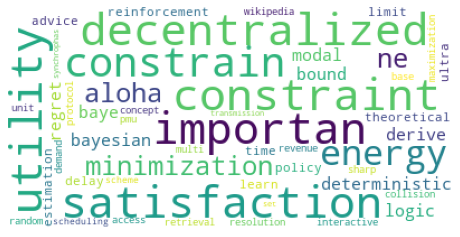

In [ ]:
mpl.rcParams['figure.figsize']=(8.0,8.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=50, max_font_size=40, random_state=42).generate(str(df_part2.lemma))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

Per instruction, we will perform LDAmodel on two size of dataset, 1k and 20k.

In [ ]:
# Dataset
docs_1k = df_part2['lemma'][0:1000].tolist() #Size 1
docs_20k = df_part2['lemma'][0:20000].tolist() #Size 2

# Copy raw data for preview
raw_docs_1k =  df_part2['Abstract'][0:1000].tolist()
raw_docs_20k = df_part2['Abstract'][0:20000].tolist()

# Preview data
print(len(docs_1k))
print(docs_1k[0][0:200])

1000
decentralized constraint satisfaction important resource allocation problem wireless network fit common framework constraint satisfaction problem csp . inspire requirement application variable locate 


We will split preprocess in to token then we remove rare words and common words based on their *document frequency*.

Below we remove words that appear in less than 25 documents or in more than
25% of the documents. Consider trying to remove words only based on their
frequency, or maybe combining that with this approach.

**Remark**: It might be better to use different threshold for different datasize (because appear in 25 documents has more possibility with larger datasize and will not filtered anything). However, as we would like to compare result so we'll fix with this value.


In [ ]:
# Tokenized preprocessing data
docs_1k = [doc.split(' ') for doc in docs_1k]
docs_20k = [doc.split(' ') for doc in docs_20k]

# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary1k = Dictionary(docs_1k)
dictionary20k = Dictionary(docs_20k)

# Filter out words that occur less than 25 documents, or more than 50% of the documents.
dictionary1k.filter_extremes(no_below=25, no_above=0.25)
dictionary20k.filter_extremes(no_below=25, no_above=0.25)

2021-04-20 23:28:39,551 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-04-20 23:28:39,648 : INFO : built Dictionary(8636 unique tokens: ['.', 'able', 'algorithm', 'allocation', 'application']...) from 1000 documents (total 92376 corpus positions)
2021-04-20 23:28:39,649 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-04-20 23:28:40,573 : INFO : adding document #10000 to Dictionary(30873 unique tokens: ['.', 'able', 'algorithm', 'allocation', 'application']...)
2021-04-20 23:28:41,505 : INFO : built Dictionary(46461 unique tokens: ['.', 'able', 'algorithm', 'allocation', 'application']...) from 20000 documents (total 1841137 corpus positions)
2021-04-20 23:28:41,533 : INFO : discarding 8117 tokens: [('.', 999), ('algorithm', 265), ('allocation', 24), ('assignment', 11), ('benchmark', 23), ('best', 16), ('centralize', 2), ('centralized', 9), ('communicate', 11), ('competitive', 15)]...
2021-04-20 23:28:41,535 : INFO : keeping 519 tokens which were

Finally, we transform the documents to a vectorized form. We simply compute
the frequency of each word, including the bigrams.




In [ ]:
# Bag-of-words representation of the documents.
corpus1k = [dictionary1k.doc2bow(doc) for doc in docs_1k]
corpus20k = [dictionary20k.doc2bow(doc) for doc in docs_20k]

Let's see how many tokens and documents we have to train on.




In [ ]:
print('Number of unique tokens: %d' % len(dictionary1k))
print('Number of documents: %d' % len(corpus1k))
print()
print('Number of unique tokens: %d' % len(dictionary20k))
print('Number of documents: %d' % len(corpus20k))

Number of unique tokens: 519
Number of documents: 1000

Number of unique tokens: 4021
Number of documents: 20000


Now we can save the corpus and the dictionary for later loading to drive the visualization on pre-built models.

### Training
--------

For our comparison, we will build 4 models with different parameters as below
- Datasize : 1k and 20k
- Number of Topic (clusters): 3 and 10


In [ ]:
def train_LDA(dictionary,corpus,NUM_TOPICS = 10, chunksize = 2000, passes = 20, iterations = 400, eval_every = None):
    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=NUM_TOPICS,
        passes=passes,
        eval_every=eval_every
    )
    outputfile = f'model_ds{len(corpus)}_topic{NUM_TOPICS}.gensim'
    print("Saving model in " + outputfile)
    print("")
    model.save(DATA_PATH+"/model/"+outputfile)
    return model

LDAmodel_3_1k = train_LDA(dictionary1k, corpus1k, NUM_TOPICS = 3)
LDAmodel_10_1k = train_LDA(dictionary1k, corpus1k, NUM_TOPICS = 10)
LDAmodel_3_20k = train_LDA(dictionary20k, corpus20k, NUM_TOPICS = 3)
LDAmodel_10_20k = train_LDA(dictionary20k, corpus20k, NUM_TOPICS = 10)

2021-04-20 23:28:43,197 : INFO : using autotuned alpha, starting with [0.33333334, 0.33333334, 0.33333334]
2021-04-20 23:28:43,199 : INFO : using serial LDA version on this node
2021-04-20 23:28:43,203 : INFO : running online (multi-pass) LDA training, 3 topics, 20 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-04-20 23:28:43,206 : INFO : PROGRESS: pass 0, at document #1000/1000
2021-04-20 23:28:45,815 : INFO : optimized alpha [0.09712745, 0.11339201, 0.08359967]
2021-04-20 23:28:45,820 : INFO : topic #0 (0.097): 0.014*"system" + 0.013*"graph" + 0.012*"datum" + 0.012*"time" + 0.011*"method" + 0.010*"number" + 0.009*"model" + 0.009*"approach" + 0.008*"set" + 0.008*"provide"
2021-04-20 23:28:45,823 : INFO : topic #1 (0.113): 0.020*"network" + 0.018*"model" + 0.013*"system" + 0.012*"information" + 0.012*"user" + 0.010*"channel" + 0.008*"time" 

Saving model in model_ds1000_topic3.gensim



2021-04-20 23:28:57,629 : INFO : saved /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds1000_topic3.gensim.state
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

2021-04-20 23:28:57,892 : INFO : saving LdaModel object under /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds1000_topic3.gensim, separately ['expElogbeta', 'sstats']
2021-04-20 23:28:57,893 : INFO : storing np array 'expElogbeta' to /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds1000_topic3.gensim.expElogbeta.npy
2021-04-20 23:28:58,229 : INFO : not storing attribute id2word
2021-04-20 23:28:58,232 : INFO : not storing attribute state
2021-04-20 23:28:58,233 : INFO : not storing attribute dispatcher
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is d

Saving model in model_ds1000_topic10.gensim



2021-04-20 23:29:11,996 : INFO : saved /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds1000_topic10.gensim.state
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

2021-04-20 23:29:12,208 : INFO : saving LdaModel object under /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds1000_topic10.gensim, separately ['expElogbeta', 'sstats']
2021-04-20 23:29:12,210 : INFO : storing np array 'expElogbeta' to /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds1000_topic10.gensim.expElogbeta.npy
2021-04-20 23:29:12,596 : INFO : not storing attribute id2word
2021-04-20 23:29:12,597 : INFO : not storing attribute state
2021-04-20 23:29:12,599 : INFO : not storing attribute dispatcher
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function i

Saving model in model_ds20000_topic3.gensim



2021-04-20 23:32:24,403 : INFO : saved /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds20000_topic3.gensim.state
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

2021-04-20 23:32:24,672 : INFO : saving LdaModel object under /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds20000_topic3.gensim, separately ['expElogbeta', 'sstats']
2021-04-20 23:32:24,674 : INFO : storing np array 'expElogbeta' to /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds20000_topic3.gensim.expElogbeta.npy
2021-04-20 23:32:25,057 : INFO : not storing attribute id2word
2021-04-20 23:32:25,059 : INFO : not storing attribute state
2021-04-20 23:32:25,060 : INFO : not storing attribute dispatcher
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function i

Saving model in model_ds20000_topic10.gensim



2021-04-20 23:36:14,843 : INFO : saved /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds20000_topic10.gensim.state
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

2021-04-20 23:36:15,070 : INFO : saving LdaModel object under /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds20000_topic10.gensim, separately ['expElogbeta', 'sstats']
2021-04-20 23:36:15,075 : INFO : storing np array 'expElogbeta' to /content/drive/MyDrive/FIT5212/data/ass1//model/model_ds20000_topic10.gensim.expElogbeta.npy
2021-04-20 23:36:15,522 : INFO : not storing attribute id2word
2021-04-20 23:36:15,533 : INFO : not storing attribute state
2021-04-20 23:36:15,535 : INFO : not storing attribute dispatcher
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This functio

We can compute the topic coherence of each topic. Below we display the
average topic coherence and print the topics in order of topic coherence.


In [ ]:
# # Load a potentially pretrained model from disk.
# LDAmodel_3_1k = LdaModel.load(DATA_PATH+"/model2/"+'model_ds1000_topic3.gensim')
# LDAmodel_10_1k = LdaModel.load(DATA_PATH+"/model2/"+'model_ds1000_topic10.gensim')
# LDAmodel_3_20k = LdaModel.load(DATA_PATH+"/model2/"+'model_ds20000_topic3.gensim')
# LDAmodel_10_20k = LdaModel.load(DATA_PATH+"/model2/"+'model_ds20000_topic10.gensim')

In [ ]:
def topic_coherence(model,corpus):
    top_topics = model.top_topics(corpus) #, num_words=20)

    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    avg_topic_coherence = sum([t[1] for t in top_topics]) / model.num_topics
    print('Average topic coherence: %.4f.' % avg_topic_coherence)

    for i in model.print_topics(num_words=20):
        print(i)

topic_coherence(LDAmodel_3_1k,corpus1k)
print()
topic_coherence(LDAmodel_10_1k,corpus1k)
print()
topic_coherence(LDAmodel_3_20k,corpus20k)
print()
topic_coherence(LDAmodel_10_20k,corpus20k)

2021-04-20 23:36:15,989 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-04-20 23:36:16,003 : INFO : topic #0 (0.099): 0.021*"model" + 0.014*"system" + 0.014*"method" + 0.014*"datum" + 0.012*"approach" + 0.012*"time" + 0.007*"provide" + 0.007*"set" + 0.007*"analysis" + 0.007*"language" + 0.007*"graph" + 0.007*"new" + 0.007*"application" + 0.007*"technique" + 0.007*"use" + 0.006*"different" + 0.006*"design" + 0.006*"structure" + 0.006*"number" + 0.006*"framework"
2021-04-20 23:36:16,005 : INFO : topic #1 (0.056): 0.041*"network" + 0.026*"channel" + 0.019*"user" + 0.016*"information" + 0.014*"system" + 0.010*"node" + 0.010*"power" + 0.010*"scheme" + 0.010*"service" + 0.010*"energy" + 0.010*"protocol" + 0.009*"interference" + 0.009*"model" + 0.009*"relay" + 0.009*"performance" + 0.008*"time" + 0.008*"rate" + 0.008*"source" + 0.008*"multiple" + 0.008*"capacity"
2021-04-20 23:36:16,010 : INFO : topic #2 (0.058): 0.030*"code" + 0.015*"bound" + 0.013*"linear" + 0.013*"mat

Average topic coherence: -1.9286.
(0, '0.021*"model" + 0.014*"system" + 0.014*"method" + 0.014*"datum" + 0.012*"approach" + 0.012*"time" + 0.007*"provide" + 0.007*"set" + 0.007*"analysis" + 0.007*"language" + 0.007*"graph" + 0.007*"new" + 0.007*"application" + 0.007*"technique" + 0.007*"use" + 0.006*"different" + 0.006*"design" + 0.006*"structure" + 0.006*"number" + 0.006*"framework"')
(1, '0.041*"network" + 0.026*"channel" + 0.019*"user" + 0.016*"information" + 0.014*"system" + 0.010*"node" + 0.010*"power" + 0.010*"scheme" + 0.010*"service" + 0.010*"energy" + 0.010*"protocol" + 0.009*"interference" + 0.009*"model" + 0.009*"relay" + 0.009*"performance" + 0.008*"time" + 0.008*"rate" + 0.008*"source" + 0.008*"multiple" + 0.008*"capacity"')
(2, '0.030*"code" + 0.015*"bound" + 0.013*"linear" + 0.013*"matrix" + 0.013*"graph" + 0.012*"number" + 0.010*"give" + 0.010*"complexity" + 0.009*"bind" + 0.008*"function" + 0.008*"set" + 0.008*"case" + 0.008*"low" + 0.008*"error" + 0.008*"size" + 0.008

2021-04-20 23:36:16,216 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2021-04-20 23:36:16,240 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2021-04-20 23:36:16,261 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2021-04-20 23:36:16,280 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2021-04-20 23:36:16,300 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2021-04-20 23:36:16,319 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2021-04-20 23:36:16,338 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2021-04-20 23:36:16,358 : INFO : CorpusAccumulator accumulated stats from 12000 documents
2021-04-20 23:36:16,376 : INFO : CorpusAccumulator accumulated stats from 13000 documents
2021-04-20 23:36:16,396 : INFO : CorpusAccumulator accumulated stats from 14000 documents
2021-04-20 23:36:16,415 : INFO : CorpusAccumulator accumulated stats from 15000 documents
2021-04-20 23:3

Average topic coherence: -1.9182.
(0, '0.022*"network" + 0.021*"channel" + 0.020*"code" + 0.012*"rate" + 0.010*"scheme" + 0.010*"node" + 0.009*"power" + 0.008*"performance" + 0.008*"capacity" + 0.008*"user" + 0.007*"signal" + 0.007*"energy" + 0.007*"information" + 0.007*"wireless" + 0.006*"protocol" + 0.006*"communication" + 0.006*"interference" + 0.006*"optimal" + 0.006*"source" + 0.006*"error"')
(1, '0.011*"network" + 0.010*"datum" + 0.007*"approach" + 0.007*"method" + 0.007*"information" + 0.005*"application" + 0.005*"use" + 0.005*"image" + 0.005*"analysis" + 0.005*"time" + 0.005*"process" + 0.005*"different" + 0.004*"provide" + 0.004*"study" + 0.004*"new" + 0.004*"design" + 0.004*"user" + 0.004*"performance" + 0.004*"feature" + 0.004*"technique"')
(2, '0.012*"graph" + 0.009*"set" + 0.009*"function" + 0.009*"time" + 0.008*"number" + 0.008*"method" + 0.006*"linear" + 0.006*"give" + 0.005*"case" + 0.005*"bound" + 0.005*"matrix" + 0.005*"class" + 0.005*"complexity" + 0.005*"new" + 0.00

2021-04-20 23:36:16,807 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2021-04-20 23:36:16,833 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2021-04-20 23:36:16,859 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2021-04-20 23:36:16,895 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2021-04-20 23:36:16,921 : INFO : CorpusAccumulator accumulated stats from 12000 documents
2021-04-20 23:36:16,954 : INFO : CorpusAccumulator accumulated stats from 13000 documents
2021-04-20 23:36:16,982 : INFO : CorpusAccumulator accumulated stats from 14000 documents
2021-04-20 23:36:17,009 : INFO : CorpusAccumulator accumulated stats from 15000 documents
2021-04-20 23:36:17,034 : INFO : CorpusAccumulator accumulated stats from 16000 documents
2021-04-20 23:36:17,060 : INFO : CorpusAccumulator accumulated stats from 17000 documents
2021-04-20 23:36:17,089 : INFO : CorpusAccumulator accumulated stats from 18000 documents
2021-04-20 2

Average topic coherence: -2.2415.
(0, '0.015*"design" + 0.013*"application" + 0.010*"datum" + 0.008*"key" + 0.008*"control" + 0.008*"performance" + 0.007*"security" + 0.007*"signal" + 0.007*"protocol" + 0.007*"scheme" + 0.007*"time" + 0.007*"architecture" + 0.007*"provide" + 0.007*"implementation" + 0.007*"high" + 0.006*"technique" + 0.006*"use" + 0.006*"device" + 0.006*"attack" + 0.006*"memory"')
(1, '0.042*"channel" + 0.025*"code" + 0.021*"rate" + 0.015*"capacity" + 0.014*"scheme" + 0.013*"interference" + 0.012*"user" + 0.011*"relay" + 0.011*"signal" + 0.011*"source" + 0.010*"information" + 0.009*"error" + 0.009*"multiple" + 0.009*"performance" + 0.008*"receiver" + 0.008*"power" + 0.008*"achieve" + 0.007*"transmission" + 0.007*"decode" + 0.007*"mimo"')
(2, '0.057*"graph" + 0.026*"time" + 0.022*"set" + 0.018*"number" + 0.017*"tree" + 0.015*"bound" + 0.015*"edge" + 0.014*"vertex" + 0.011*"bind" + 0.010*"give" + 0.009*"size" + 0.009*"complexity" + 0.009*"approximation" + 0.008*"prove" +

### Visualisation


In [ ]:
lda_display_3_1k = pyLDAvis.gensim.prepare(LDAmodel_3_1k, corpus1k, dictionary1k, sort_topics=False)
pyLDAvis.display(lda_display_3_1k)

2021-04-20 23:36:20,267 : INFO : NumExpr defaulting to 2 threads.


In [ ]:
lda_display_3_20k = pyLDAvis.gensim.prepare(LDAmodel_3_20k, corpus20k, dictionary20k, sort_topics=False)
pyLDAvis.display(lda_display_3_20k)

In [ ]:
lda_display_10_1k = pyLDAvis.gensim.prepare(LDAmodel_10_1k, corpus1k, dictionary1k, sort_topics=False)
pyLDAvis.display(lda_display_10_1k)

In [ ]:
lda_display_10_20k = pyLDAvis.gensim.prepare(LDAmodel_10_20k, corpus20k, dictionary20k, sort_topics=False)
pyLDAvis.display(lda_display_10_20k)

Let's map out data with original documensts and preview some of the relevant.

In [ ]:
def get_document_topics(ldamodel, corpus, texts):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df

In [ ]:
doc_topic_df_3_1k = get_document_topics(ldamodel=LDAmodel_3_1k, corpus=corpus1k, texts=raw_docs_1k)
doc_topic_df_10_1k = get_document_topics(ldamodel=LDAmodel_10_1k, corpus=corpus1k, texts=raw_docs_1k)
doc_topic_df_3_20k = get_document_topics(ldamodel=LDAmodel_3_20k, corpus=corpus20k, texts=raw_docs_20k)
doc_topic_df_10_20k = get_document_topics(ldamodel=LDAmodel_10_20k, corpus=corpus20k, texts=raw_docs_20k)

In [ ]:
doc_topic_df_3_1k.head(3)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original_Text
0,0.0,0.4407,"model, system, method, datum, approach, time, ...",Decentralized Constraint Satisfaction We show...
1,1.0,0.9965,"network, channel, user, information, system, n...",Utility Constrained Energy Minimization In Al...
2,0.0,0.9962,"model, system, method, datum, approach, time, ...",Deterministic modal Bayesian Logic: derive th...


List only top representation document that made that cluster of Topic. 

In [ ]:
def top_representation(df_topic, n=1):
    # Group top n sentences under each topic
    doc_topics_sorted_df = pd.DataFrame()

    doc_topic_df_grpd = df_topic.groupby('Dominant_Topic')

    for i, grp in doc_topic_df_grpd:
        doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                                grp.sort_values(['Perc_Contribution'], ascending=[0]).head(n)], 
                                                axis=0)

    doc_topics_sorted_df.reset_index(drop=True, inplace=True)
    doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    return doc_topics_sorted_df

In [ ]:
top_rep_3_1k = top_representation(doc_topic_df_3_1k,3)
top_rep_10_1k = top_representation(doc_topic_df_10_1k,1)
top_rep_3_20k = top_representation(doc_topic_df_3_20k,3)
top_rep_10_20k = top_representation(doc_topic_df_10_20k,1)

In [ ]:
top_rep_3_1k

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9989,"model, system, method, datum, approach, time, ...",Continuous-time Infinite Dynamic Topic Models...
1,0.0,0.9989,"model, system, method, datum, approach, time, ...",Adaptive Parallel Iterative Deepening Search ...
2,0.0,0.9988,"model, system, method, datum, approach, time, ...",Graph-Structured Multi-task Regression and an...
3,1.0,0.9985,"network, channel, user, information, system, n...",Optimizing Orthogonal Multiple Access based o...
4,1.0,0.9985,"network, channel, user, information, system, n...",On the Capacity and Diversity-Multiplexing Tr...
5,1.0,0.9984,"network, channel, user, information, system, n...",Competitive Ratio Analysis of Online Algorith...
6,2.0,0.9986,"code, bound, linear, matrix, graph, number, gi...",Performance Analysis of 3-Dimensional Turbo C...
7,2.0,0.9983,"code, bound, linear, matrix, graph, number, gi...",Exponential decay of reconstruction error fro...
8,2.0,0.9981,"code, bound, linear, matrix, graph, number, gi...",Sketching Sparse Matrices This paper consider...


### Discussion & Conclusion

We start with comparing our results that we choose to cluster our 'Abstract' into 3 topics. This is because we know from our raw data that there are supposed to be labels (Math, InfoTheory, DataVis). Our expectation from our data is that one 'Abstract' could lead into more than 1 topic. That means if we cluster into 3 topics there should be some overlap between each cluster.


However, our LDA Model results for both 1k dataset and 20k dataset display 3 topics that are totally separated. This means that LDAmodel recognizes some patterns that can differentiate each topic out from one another. Let's look into each model to see if we could manually identify 'Topic Name'.

In [ ]:
# LDAmodel with 3 topic from 1k dataset
for i in range(len(top_rep_3_1k)):
    print("Topic :",int(top_rep_3_1k['Topic_Num'][i]),",Keywords :",top_rep_3_1k['Keywords'][i])
    print(top_rep_3_1k['Text'][i])
    print("=========")

Topic : 0 ,Keywords : model, system, method, datum, approach, time, provide, set, analysis, language
 Continuous-time Infinite Dynamic Topic Models Topic models are probabilistic models for discovering topical themes in collections of documents. In real world applications, these models provide us with the means of organizing what would otherwise be unstructured collections. They can help us cluster a huge collection into different topics or find a subset of the collection that resembles the topical theme found in an article at hand. The first wave of topic models developed were able to discover the prevailing topics in a big collection of documents spanning a period of time. It was later realized that these time-invariant models were not capable of modeling 1) the time varying number of topics they discover and 2) the time changing structure of these topics. Few models were developed to address this two deficiencies. The online-hierarchical Dirichlet process models the documents with a

In [ ]:
# LDAmodel with 3 topic from 20k dataset
for i in range(len(top_rep_3_20k)):
    print("Topic :",int(top_rep_3_20k['Topic_Num'][i]),",Keywords :",top_rep_3_20k['Keywords'][i])
    print(top_rep_3_20k['Text'][i])
    print("=========")

Topic : 0 ,Keywords : network, channel, code, rate, scheme, node, power, performance, capacity, user
 Network Utility Aware Traffic Loading Balancing in Backhaul-constrained Cache-enabled Small Cell Networks with Hybrid Power Supplies Explosive data traffic growth leads to a continuous surge in capacity demands across mobile networks. In order to provision high network capacity, small cell base stations (SCBSs) are widely deployed. Owing to the close proximity to mobile users, SCBSs can effectively enhance the network capacity and offloading traffic load from macro BSs (MBSs). However, the cost-effective backhaul may not be readily available for SCBSs, thus leading to backhaul constraints in small cell networks (SCNs). Enabling cache in BSs may mitigate the backhaul constraints in SCNs. Moreover, the dense deployment of SCBSs may incur excessive energy consumption. To alleviate brown power consumption, renewable energy will be explored to power BSs. In such a network, it is challenging

One of the 3 Topics of both 1k and 20k dataset has keywords such as "set, function, number, linear" which we could probably guess it's Math related. However, the other 2 topics are quite hard to distinguish as keywords are quick overlap. Even after looking at the original text it is still hard to differentiate. It might be because you need more domain experts to be able to group it out.

Let's explore the topic using wordcloud in 20k dataset with 3 topics, this might give us more idea of what each topic is about

Topic 0


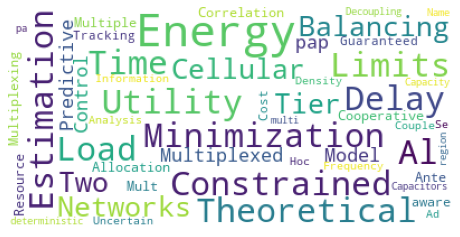

----------------------
Topic 1


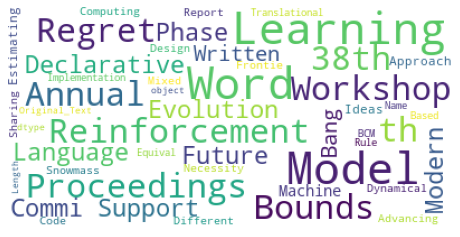

----------------------
Topic 2


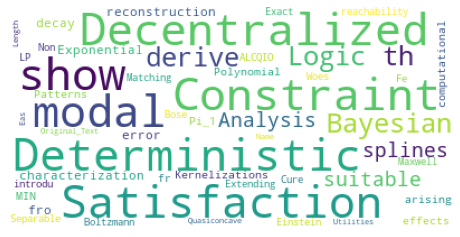

----------------------


In [ ]:
for i in range(3):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=50, max_font_size=40, random_state=42).generate(str(doc_topic_df_3_20k[doc_topic_df_3_20k.Dominant_Topic == i].Original_Text))
    print("Topic",i)
    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();
    print("----------------------")

It looks much more easier to interpret but the keyword theme is not obvious to form a topic name

Now lets explore when we change to 10 clusters of Topics. From above graph, we see that some of the topics are not 100%

In [ ]:
# LDAmodel with 10 topic from 1k dataset
for i in range(len(top_rep_10_1k)):
    print("Topic :",int(top_rep_10_1k['Topic_Num'][i]),",Keywords :",top_rep_10_1k['Keywords'][i])
    print(top_rep_10_1k['Text'][i])
    print("=========")

In [ ]:
# LDAmodel with 10 topic from 20k dataset
for i in range(len(top_rep_10_20k)):
    print("Topic :",int(top_rep_10_20k['Topic_Num'][i]),",Keywords :",top_rep_10_20k['Keywords'][i])
    print(top_rep_10_20k['Text'][i])
    print("=========")

After increasing the cluster into 10 topics, we could see more variety of words and easier to identify it's topic. The keywords still have some overlap but we could now guess some of the topic is about. However, some topics might look similar and should be grouped together.

Example


```
Topic : 2 Keywords : network, social, study, cluster, dynamic, structure, information, pattern, different, complex
 Co-evolutionary dynamics in social networks: A case study of Twitter Complex networks often exhibit co-evolutionary dynamics, meaning that the network topology and the state of nodes or links are coupled, affecting each other in overlapping time scales. We focus on the co-evolutionary dynamics of online social networks, and on Twitter in particular. Monitoring the activity of thousands of Twitter users in real-time, and tracking their followers and tweets/retweets, we propose a method to infer new retweet-driven follower relations. The formation of such relations is much more likely than the exogenous creation of new followers in the absence of any retweets. We identify the most significant factors (reciprocity and the number of retweets that a potential new follower receives) and propose a simple probabilistic model of this effect. We also discuss the implications of such co-evolutionary dynamics on the topology and function of a social network. 
```
We could guess it's something about "Social Network" within this topic. And...

```
Topic : 1 Keywords : quantum, function, protocol, key, complexity, scheme, set, attack, property, group
 An efficient dynamic ID based remote user authentication scheme using self-certified public keys for multi-server environment Recently, Li et al. analyzed Lee et al.'s multi-server authentication scheme and proposed a novel smart card and dynamic ID based remote user authentication scheme for multi-server environments. They claimed that their scheme can resist several kinds of attacks. However, through careful analysis, we find that Li et al.'s scheme is vulnerable to stolen smart card and offline dictionary attack, replay attack, impersonation attack and server spoofing attack. By analyzing other similar schemes, we find that the certain type of dynamic ID based multi-server authentication scheme in which only hash functions are used and no registration center participates in the authentication and session key agreement phase is hard to provide perfect efficient and secure authentication. To compensate for these shortcomings, we improve the recently proposed Liao et al.'s multi-server authentication scheme which is based on pairing and self-certified public keys, and propose a novel dynamic ID based remote user authentication scheme for multi-server environments. Liao et al.'s scheme is found vulnerable to offline dictionary attack and denial of service attack, and cannot provide user's anonymity and local password verification. However, our proposed scheme overcomes the shortcomings of Liao et al.'s scheme. Security and performance analyses show the proposed scheme is secure against various attacks and has many excellent features. 
```
which we could probably guess about cyber security key from it's keywords.


Similiarly Let's try if wordclouds could help with 20k data 10 topics

Topic 0


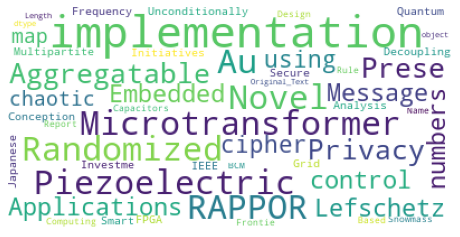

----------------------
Topic 1


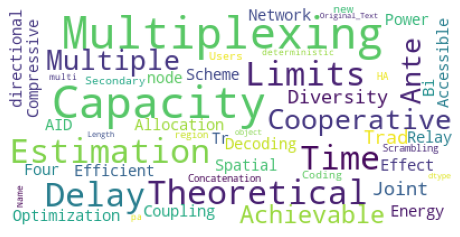

----------------------
Topic 2


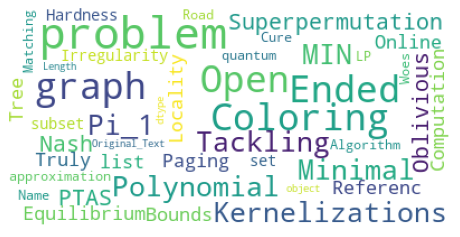

----------------------
Topic 3


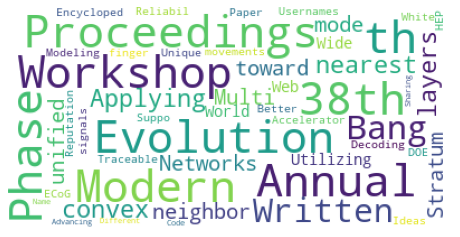

----------------------
Topic 4


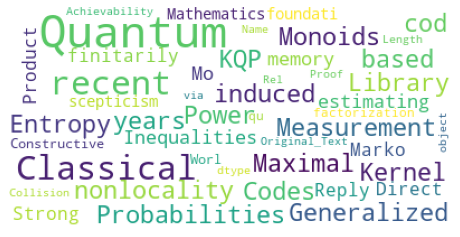

----------------------
Topic 5


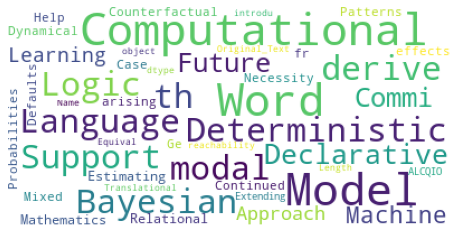

----------------------
Topic 6


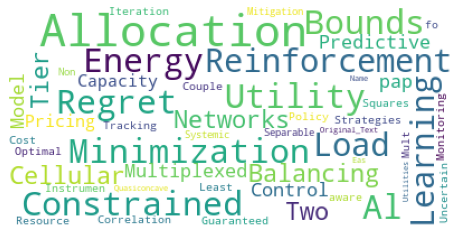

----------------------
Topic 7


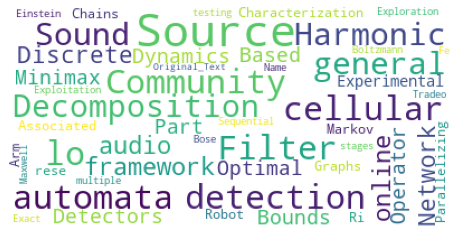

----------------------
Topic 8


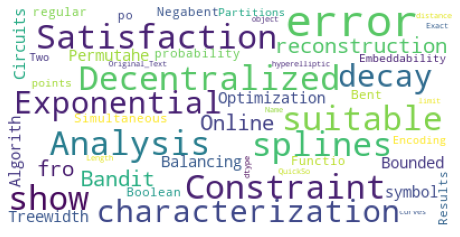

----------------------
Topic 9


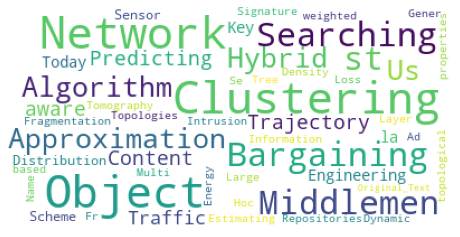

----------------------


In [ ]:
for i in range(10):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=50, max_font_size=40, random_state=42).generate(str(doc_topic_df_10_20k[doc_topic_df_10_20k.Dominant_Topic == i].Original_Text))
    print("Topic",i)
    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();
    print("----------------------")

It does look easier to interpret for some topic for example. "Network, Algoritm, Clustering" that could be subject about "algorithm to group data together". However, it is still hard to be able to come-up with all topic names.



In summary, we compare 4 models with 2 different configuration variables. Having more clusters defined will help us be easier to identify what the topic is about. However, it also creates more chances that the topic should be merged. While the number of documents might not be relevant to the number of topics, if it does not give unique patterns. 

Moreover, Unsupervised learning can display different clusters than what we expected. This leads to fine-tuning hyperparameters to understand what each cluster's topic is supposed to be.